In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk

/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
file_path = ('/Users/steven.souksavath/Downloads/Recipe Reviews and User Feedback Dataset.csv')
df = pd.read_csv(file_path)

In [3]:
# Remove Duplicate Recipes

#  Store original shape for comparison
original_shape = df.shape

# Drop duplicates in-place based on comment text, user_id, and recipe_code
df.drop_duplicates(
    subset=['text', 'user_id', 'recipe_code'],
    keep='first',
    inplace=True
)

# Show the impact of duplication
print("Original dataset shape:", original_shape)
print("Dataset shape after removing duplicates:", df.shape)
print(f"Removed {original_shape[0] - df.shape[0]} duplicate comments")

#Dropping variables
df.isnull().sum()
df.dropna()


#Fixing the column name
df.rename(columns={'Unnamed: 0': 'num_records'}, inplace=True)


#Change "created at" variable to univerex to UTC

df['created_at_utc'] = pd.to_datetime(df['created_at'], unit='s', utc=True)

Original dataset shape: (18182, 15)
Dataset shape after removing duplicates: (17880, 15)
Removed 302 duplicate comments


In [4]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/steven.souksavath/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/steven.souksavath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/steven.souksavath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Replace NaN values with an empty string and convert all values to strings
df['text'] = df['text'].fillna('').astype(str)

In [6]:
# Preprocessing function for text
def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove special characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing directly to the 'text' column - Text is already tokenized
df['text'] = df['text'].apply(preprocess_text)

In [7]:
from gensim.models import Word2Vec

# Prepare data for Word2Vec
sentences = df['text'].tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1)

In [8]:
# Function to compute average Word2Vec embedding for a sentence
def get_sentence_vector(tokens, model):
    # Get vectors for words that exist in the Word2Vec vocabulary
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    # Return the average vector (or a zero vector if no words in vocabulary)
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Apply the function to each tokenized text in the dataset
df['sentence_vector'] = df['text'].apply(lambda x: get_sentence_vector(x, word2vec_model))

In [9]:
#Function for user sentiment

def sentiment_label(row):
    if row['stars'] >= 4 or row['stars'] == 0:
        return 1  # Positive Sentiment
    else:
        return 0  # Negetive sentiment

df['sentiment'] = df.apply(sentiment_label, axis=1)

In [10]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Clean text data
df['cleaned_text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', str(x).lower().strip()))

# Tokenize text
tokenizer = Tokenizer(num_words=10000)  # Use top 10,000 words
tokenizer.fit_on_texts(df['cleaned_text'])

sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences
max_length = 200  # Max length for padding

X = pad_sequences(sequences, maxlen=max_length)

# Prepare target variable
y = df['sentiment'].values

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights at the end
)

# RNN

In [14]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Custom F1 Score Metric for Binary Classification
class BinaryF1Score(Metric):
    def __init__(self, name='binary_f1_score', **kwargs):
        super(BinaryF1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Convert probabilities to binary predictions
        y_true = tf.cast(y_true, tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

# Define the RNN model for Binary Classification
rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),  # Embedding layer
    LSTM(64, return_sequences=False),  # LSTM layer
    Dropout(0.5),  # Dropout for regularization
    Dense(32, activation='relu'),  # Fully connected layer
    BatchNormalization(),  # Batch Normalization after Dense
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Compile the model
rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=[BinaryF1Score(), 'accuracy']  # Use custom F1 metric and accuracy
)

# Train the model
rnn_model.fit(
    X_train, y_train,  # Ensure y_train contains binary labels (0 or 1)
    validation_data=(X_test, y_test),  # Ensure y_test contains binary labels (0 or 1)
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/5


/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


447/447 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.8508 - binary_f1_score: 0.9132 - loss: 0.4273 - val_accuracy: 0.9446 - val_binary_f1_score: 0.9715 - val_loss: 0.1889
Epoch 2/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.9613 - binary_f1_score: 0.9591 - loss: 0.1239 - val_accuracy: 0.9390 - val_binary_f1_score: 0.9463 - val_loss: 0.1775
Epoch 3/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.9695 - binary_f1_score: 0.9555 - loss: 0.0930 - val_accuracy: 0.9511 - val_binary_f1_score: 0.9654 - val_loss: 0.1820
Epoch 4/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.9775 - binary_f1_score: 0.9512 - loss: 0.0650 - val_accuracy: 0.9471 - val_binary_f1_score: 0.9605 - val_loss: 0.1949
Epoch 5/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.9839 - binary_f1_score: 0.9516 - loss: 0.0488 - val_accuracy: 0.9499 - val_binary_f1_score: 0.9643 - val_loss: 0.2092


# CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the CNN model for Binary Classification
cnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),  # Embedding layer
    Conv1D(128, 5, activation='relu'),  # 1D Convolutional layer
    GlobalMaxPooling1D(),  # Global max pooling
    Dropout(0.5),  # Dropout for regularization
    Dense(32, activation='relu'),  # Fully connected layer
    BatchNormalization(),  # Batch Normalization
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Compile the CNN model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=[BinaryF1Score(), 'accuracy']  # Include Binary F1 Score
)

# Train the CNN model
cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7817 - binary_f1_score: 0.8691 - loss: 0.4850 - val_accuracy: 0.9449 - val_binary_f1_score: 0.9714 - val_loss: 0.1686
Epoch 2/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9557 - binary_f1_score: 0.9630 - loss: 0.1342 - val_accuracy: 0.9527 - val_binary_f1_score: 0.9644 - val_loss: 0.1518
Epoch 3/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9755 - binary_f1_score: 0.9522 - loss: 0.0769 - val_accuracy: 0.9516 - val_binary_f1_score: 0.9605 - val_loss: 0.1519
Epoch 4/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9801 - binary_f1_score: 0.9507 - loss: 0.0565 - val_accuracy: 0.9494 - val_binary_f1_score: 0.9532 - val_loss: 0.1641
Epoch 5/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9867 - binary_f1_score: 0.9531 - loss: 0.0397 - val_accuracy: 0.9491 - val_binary_f1_score: 0.9565 - val_loss: 0.1994


# LSTM

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the LSTM model for Binary Classification
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),  # Embedding layer
    LSTM(64, return_sequences=False),  # LSTM layer
    Dropout(0.5),  # Dropout for regularization
    Dense(32, activation='relu'),  # Fully connected layer
    BatchNormalization(),  # Batch Normalization
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Compile the LSTM model
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=[BinaryF1Score(), 'accuracy']  # Include Binary F1 Score
)

# Train the LSTM model
lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.8560 - binary_f1_score: 0.9141 - loss: 0.4330 - val_accuracy: 0.9446 - val_binary_f1_score: 0.9715 - val_loss: 0.1911
Epoch 2/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.9585 - binary_f1_score: 0.9577 - loss: 0.1258 - val_accuracy: 0.9497 - val_binary_f1_score: 0.9677 - val_loss: 0.1713
Epoch 3/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.9690 - binary_f1_score: 0.9510 - loss: 0.0909 - val_accuracy: 0.9480 - val_binary_f1_score: 0.9658 - val_loss: 0.1867


In [17]:
print("Unique classes in y_test:", set(y_test))

Unique classes in y_test: {0, 1}


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9420 - binary_f1_score: 0.9503 - loss: 0.1694
RNN - Loss: 0.1775, Accuracy: 0.9390, Binary F1: 0.9463
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

RNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.45      0.43      0.44       198
    Positive       0.97      0.97      0.97      3378

    accuracy                           0.94      3576
   macro avg       0.71      0.70      0.70      3576
weighted avg       0.94      0.94      0.94      3576



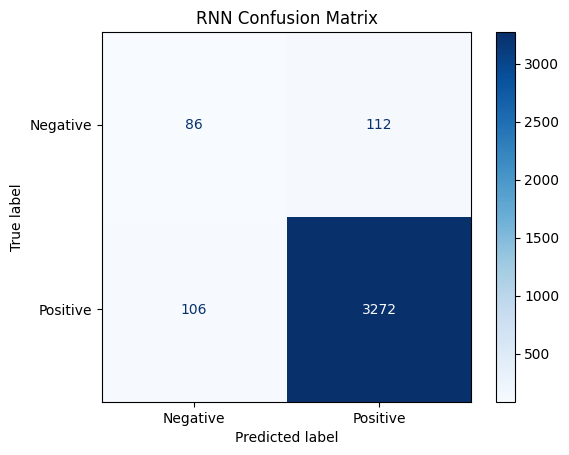

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9582 - binary_f1_score: 0.9681 - loss: 0.1336
CNN - Loss: 0.1518, Accuracy: 0.9527, Binary F1: 0.9644
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

CNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.22      0.34       198
    Positive       0.96      1.00      0.98      3378

    accuracy                           0.95      3576
   macro avg       0.86      0.61      0.66      3576
weighted avg       0.94      0.95      0.94      3576



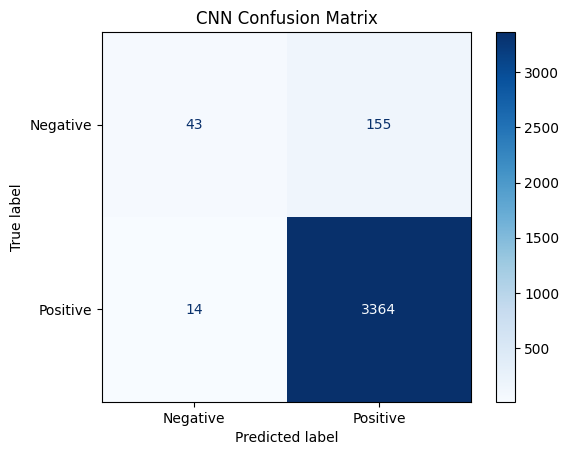

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9500 - binary_f1_score: 0.9743 - loss: 0.1787
LSTM - Loss: 0.1911, Accuracy: 0.9446, Binary F1: 0.9715
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       198
    Positive       0.94      1.00      0.97      3378

    accuracy                           0.94      3576
   macro avg       0.47      0.50      0.49      3576
weighted avg       0.89      0.94      0.92      3576



/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

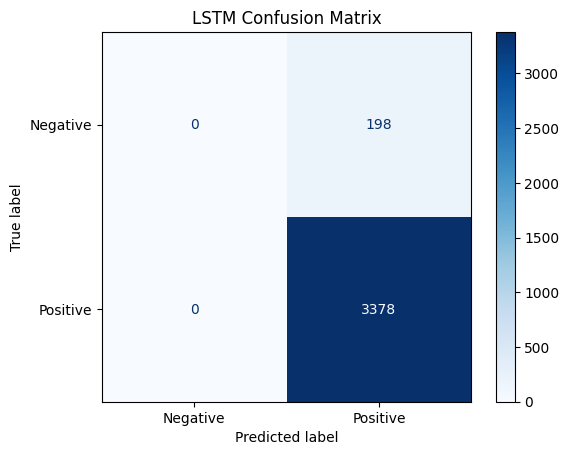

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, model_name, X_test, y_test):
    # Evaluate the model
    results = model.evaluate(X_test, y_test, verbose=1)
    print(f"{model_name} - Loss: {results[0]:.4f}, Accuracy: {results[2]:.4f}, Binary F1: {results[1]:.4f}")
    
    # Get predictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Evaluate RNN
evaluate_model(rnn_model, "RNN", X_test, y_test)

# Evaluate CNN
evaluate_model(cnn_model, "CNN", X_test, y_test)

# Evaluate LSTM
evaluate_model(lstm_model, "LSTM", X_test, y_test)